## Importing Libraries


In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras 

## Data Preperation
 
1.   Load all training and testing data

2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images with devide by 255

5.   One Hot Encoding on the labels

6.   Dividing the dataset into Training and Validation sets





In [2]:
 
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = []
y_train = []
x_test = []
y_test = []

image_size = 200

# Define the base path to your dataset
base_path = r"C:\Users\LENOVO\AMIT AI\Amit-1\myenv\Scripts\Final Project BME\classification\Brain-Tumor-MRI-Classification-main\Data"

for label in labels:
    trainPath = os.path.join(base_path, "Training", label)
    for file in tqdm(os.listdir(trainPath), desc=f"Training {label}"):
        image = cv2.imread(os.path.join(trainPath, file), 0)
        if image is not None:
            image = cv2.bilateralFilter(image, 2, 50, 50)
            image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
            image = cv2.resize(image, (image_size, image_size))
            x_train.append(image)
            y_train.append(labels.index(label))
    
    testPath = os.path.join(base_path, "Testing", label)
    for file in tqdm(os.listdir(testPath), desc=f"Testing {label}"):
        image = cv2.imread(os.path.join(testPath, file), 0)
        if image is not None:
            image = cv2.bilateralFilter(image, 2, 50, 50)
            image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
            image = cv2.resize(image, (image_size, image_size))
            x_test.append(image)
            y_test.append(labels.index(label))

# Convert lists to numpy arrays and normalize images
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

# Print dataset shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Training glioma:   0%|          | 0/1321 [00:00<?, ?it/s]

Testing pituitary: 100%|██████████| 300/300 [00:00<00:00, 365.17it/s]


x_train shape: (5712, 200, 200, 3)
y_train shape: (5712, 4)
x_test shape: (1311, 200, 200, 3)
y_test shape: (1311, 4)


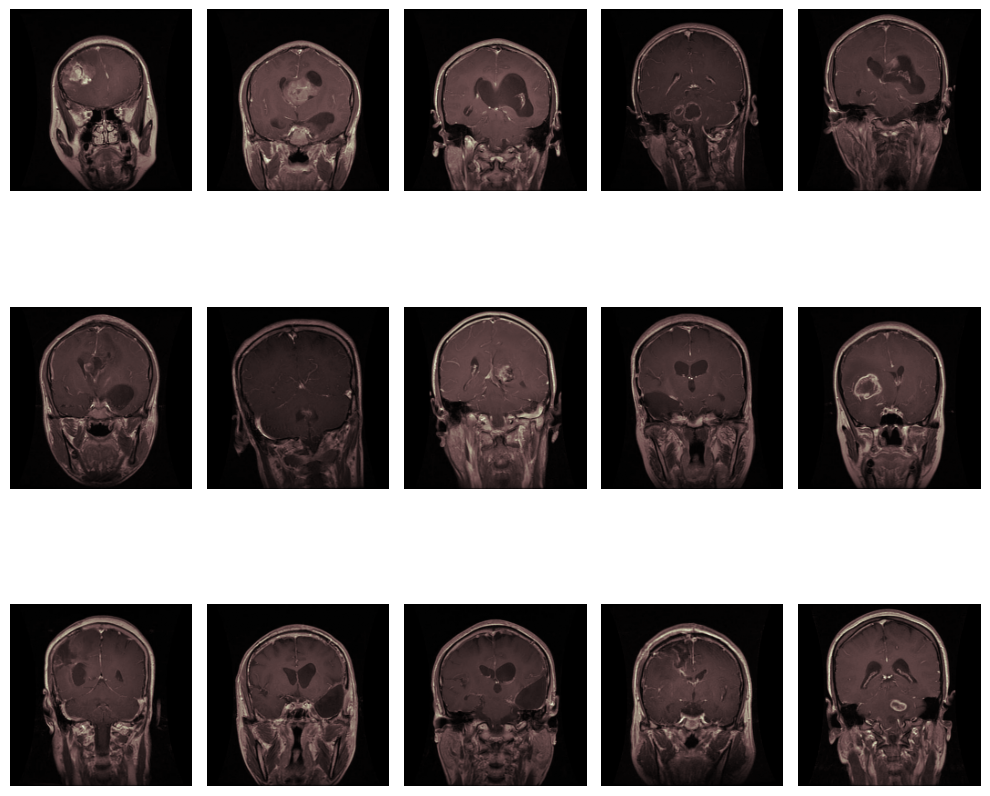

In [3]:
import matplotlib.pyplot as plt
num_images_to_show = min(15, len(x_train))

images = [x_train[i] for i in range(num_images_to_show)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img)  
    ax.axis('off') 

for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Shuffle the training data
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print("Validation set shape:", x_val.shape)


Validation set shape: (1143, 200, 200, 3)


## Data Augmentation
In order to make the most of our few training examples, we will **augment** them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent **overfitting** and helps the model generalize better.

In [5]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Pre-trained Model
Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.


In this project, I'll be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




**Note**

Setting `include_top` to `False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training



In [6]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [7]:
import keras
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Log confusion matrix to TensorBoard

With the following code you can log the confusion matrix for all epochs.

In [8]:
import os
import datetime
import tensorflow as tf

os.system('rm -rf logs') 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


In [11]:
import os
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools
import io
from sklearn.metrics import confusion_matrix
import shutil
shutil.rmtree('logs', ignore_errors=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

%load_ext tensorboard

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion Matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4912), started 13:23:05 ago. (Use '!kill 4912' to kill it.)

## Training
**callback** -> set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**LambdaCallback** ->  will log the confusion matrix on every epoch.

**ModelCheckpoint** -> callback to save the Keras model or model weights at some frequency.

**EarlyStopping** -> stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau** -> reduce learning rate when a metric has stopped improving.

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback

# Define log directory for TensorBoard
logdir = "logs"
file_writer_cm = tf.summary.create_file_writer(logdir)  # Used for writing custom logs (e.g., confusion matrix)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

# Training hyperparameters
BATCH_SIZE = 64
EPOCHS = 50

# Define callbacks
Checkpoint = ModelCheckpoint(
    filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

RL = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1,
    mode='min'
)

# Define a function to log the confusion matrix at the end of each epoch (you must define this function)
# Example:
# def log_confusion_matrix(epoch, logs):
#     cm = confusion_matrix(...)
#     figure = plot_confusion_matrix(cm, class_names=...)
#     with file_writer_cm.as_default():
#         tf.summary.image("Confusion Matrix", plot_to_image(figure), step=epoch)

callbacks = [
    ES,
    RL,
    tensorboard,
    Checkpoint,
    LambdaCallback(on_epoch_end=log_confusion_matrix)  # log_confusion_matrix must be predefined
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
) 


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9429 - loss: 0.1632 
Epoch 1: val_loss improved from inf to 3.36003, saving model to model-01-0.24-3.36.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1221s 17s/step - accuracy: 0.9431 - loss: 0.1628 - val_accuracy: 0.2380 - val_loss: 3.3600 - learning_rate: 1.0000e-04
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9757 - loss: 0.0650 
Epoch 2: val_loss improved from 3.36003 to 2.61861, saving model to model-02-0.30-2.62.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1162s 16s/step - accuracy: 0.9757 - loss: 0.0650 - val_accuracy: 0.3001 - val_loss: 2.6186 - learning_rate: 1.0000e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9889 - loss: 0.0342 
Epoch 3: val_loss improved from 2.61861 to 2.04522, saving model to model-03-0.41-2.05.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1233s 17s/step - accuracy: 0.9889 - loss: 0.0342 - val_accuracy: 0.4077 - val_loss: 2.0452 - learning_rate: 1.0000e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9939 - loss: 0.0227 
Epoch 4: val_loss did not improve from 2.04522
41/41 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1188s 16s/step - accuracy: 0.9938 - loss: 0.0228 - val_accuracy: 0.4199 - val_loss: 2.1221 - learning_rate: 1.0000e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9857 - loss: 0.0316 
Epoch 5: val_loss improved from 2.04522 to 1.89054, saving model to model-05-0.42-1.89.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1195s 17s/step - accuracy: 0.9857 - loss: 0.0316 - val_accuracy: 0.4156 - val_loss: 1.8905 - learning_rate: 1.0000e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9945 - loss: 0.0135 
Epoch 6: val_loss improved from 1.89054 to 1.78388, saving model to model-06-0.46-1.78.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1253s 17s/step - accuracy: 0.9945 - loss: 0.0135 - val_accuracy: 0.4576 - val_loss: 1.7839 - learning_rate: 1.0000e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9940 - loss: 0.0163 
Epoch 7: val_loss did not improve from 1.78388
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1186s 16s/step - accuracy: 0.9940 - loss: 0.0164 - val_accuracy: 0.4287 - val_loss: 1.8909 - learning_rate: 1.0000e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9899 - loss: 0.0288 
Epoch 8: val_loss improved from 1.78388 to 1.59947, saving model to model-08-0.47-1.60.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1176s 16s/step - accuracy: 0.9899 - loss: 0.0287 - val_accuracy: 0.4733 - val_loss: 1.5995 - learning_rate: 1.0000e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9957 - loss: 0.0123 
Epoch 9: val_loss did not improve from 1.59947
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1158s 16s/step - accuracy: 0.9957 - loss: 0.0123 - val_accuracy: 0.4689 - val_loss: 1.6542 - learning_rate: 1.0000e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9971 - loss: 0.0106 
Epoch 10: val_loss improved from 1.59947 to 1.10203, saving model to model-10-0.60-1.10.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1165s 16s/step - accuracy: 0.9971 - loss: 0.0106 - val_accuracy: 0.6002 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9955 - loss: 0.0108 
Epoch 11: val_loss improved from 1.10203 to 0.60456, saving model to model-11-0.76-0.60.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1160s 16s/step - accuracy: 0.9955 - loss: 0.0109 - val_accuracy: 0.7594 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9952 - loss: 0.0143 
Epoch 12: val_loss improved from 0.60456 to 0.23286, saving model to model-12-0.94-0.23.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1188s 17s/step - accuracy: 0.9952 - loss: 0.0144 - val_accuracy: 0.9361 - val_loss: 0.2329 - learning_rate: 1.0000e-04
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9952 - loss: 0.0226 
Epoch 13: val_loss did not improve from 0.23286
41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1175s 16s/step - accuracy: 0.9952 - loss: 0.0225 - val_accuracy: 0.9003 - val_loss: 0.3401 - learning_rate: 1.0000e-04
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9944 - loss: 0.0155 
Epoch 14: val_loss did not improve from 0.23286
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1178s 16s/step - accuracy: 0.9944 - loss: 0.0155 - val_accuracy: 0.8425 - val_loss: 0.8485 - learning_rate: 1.0000e-04
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9969 - loss: 0.0077 
Epoch 15: val_loss did not improve from 0.23286
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
72/7

41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1159s 16s/step - accuracy: 0.9942 - loss: 0.0139 - val_accuracy: 0.9764 - val_loss: 0.1092 - learning_rate: 1.0000e-04
Epoch 18/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9962 - loss: 0.0136 
Epoch 18: val_loss did not improve from 0.10924
41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1156s 16s/step - accuracy: 0.9962 - loss: 0.0137 - val_accuracy: 0.9379 - val_loss: 0.2228 - learning_rate: 1.0000e-04
Epoch 19/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9955 - loss: 0.0140 
Epoch 19: val_loss improved from 0.10924 to 0.09864, saving model to model-19-0.97-0.10.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1199s 17s/step - accuracy: 0.9954 - loss: 0.0141 - val_accuracy: 0.9738 - val_loss: 0.0986 - learning_rate: 1.0000e-04
Epoch 20/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9979 - loss: 0.0078 
Epoch 20: val_loss did not improve from 0.09864
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1232s 17s/step - accuracy: 0.9979 - loss: 0.0078 - val_accuracy: 0.9790 - val_loss: 0.1015 - learning_rate: 1.0000e-04
Epoch 21/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9972 - loss: 0.0093 
Epoch 21: val_loss did not improve from 0.09864
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1172s 16s/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.9685 - val_loss: 0.1608 - learning_rate: 1.0000e-04
Epoch 22/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9973 - loss: 0.0076 
Epoch 22: val_loss improved from 0.09864 to 0.09648, saving model to model-22-0.98-0.10.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1169s 16s/step - accuracy: 0.9973 - loss: 0.0076 - val_accuracy: 0.9799 - val_loss: 0.0965 - learning_rate: 1.0000e-04
Epoch 23/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9996 - loss: 0.0024 
Epoch 23: val_loss did not improve from 0.09648
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1148s 16s/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9851 - val_loss: 0.1026 - learning_rate: 1.0000e-04
Epoch 24/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9995 - loss: 0.0023 
Epoch 24: val_loss did not improve from 0.09648
41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1183s 16s/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9239 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 25/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9946 - loss: 0.0179 
Epoch 25: val_loss did not improve from 0.09648
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step
72/7

## Learning curves

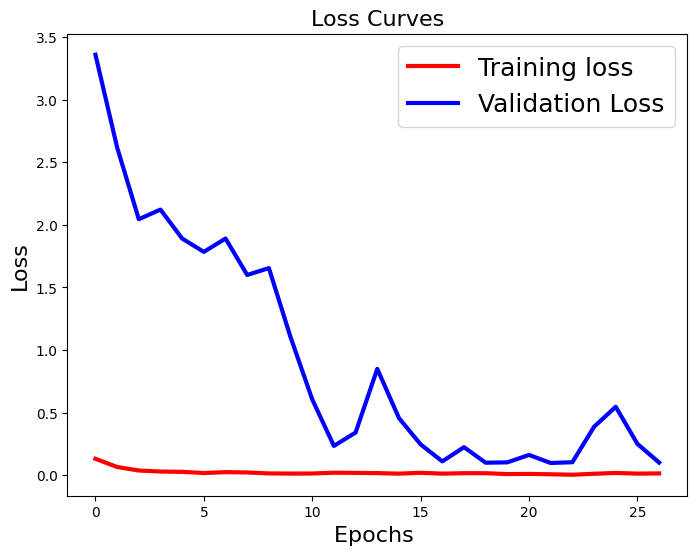

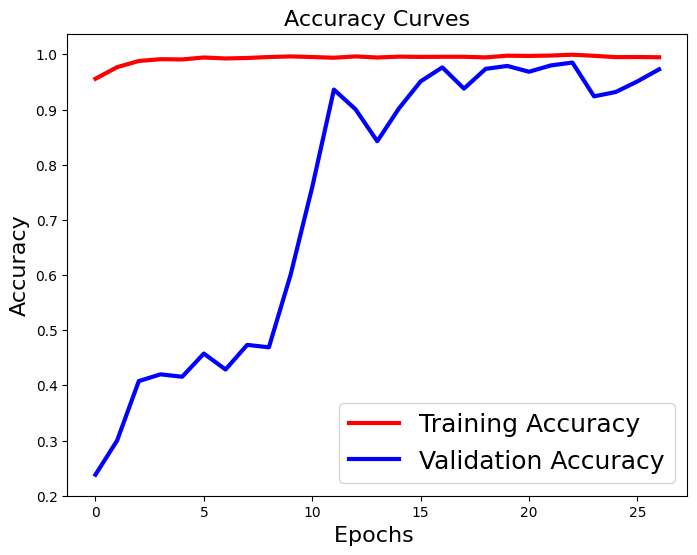

In [14]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


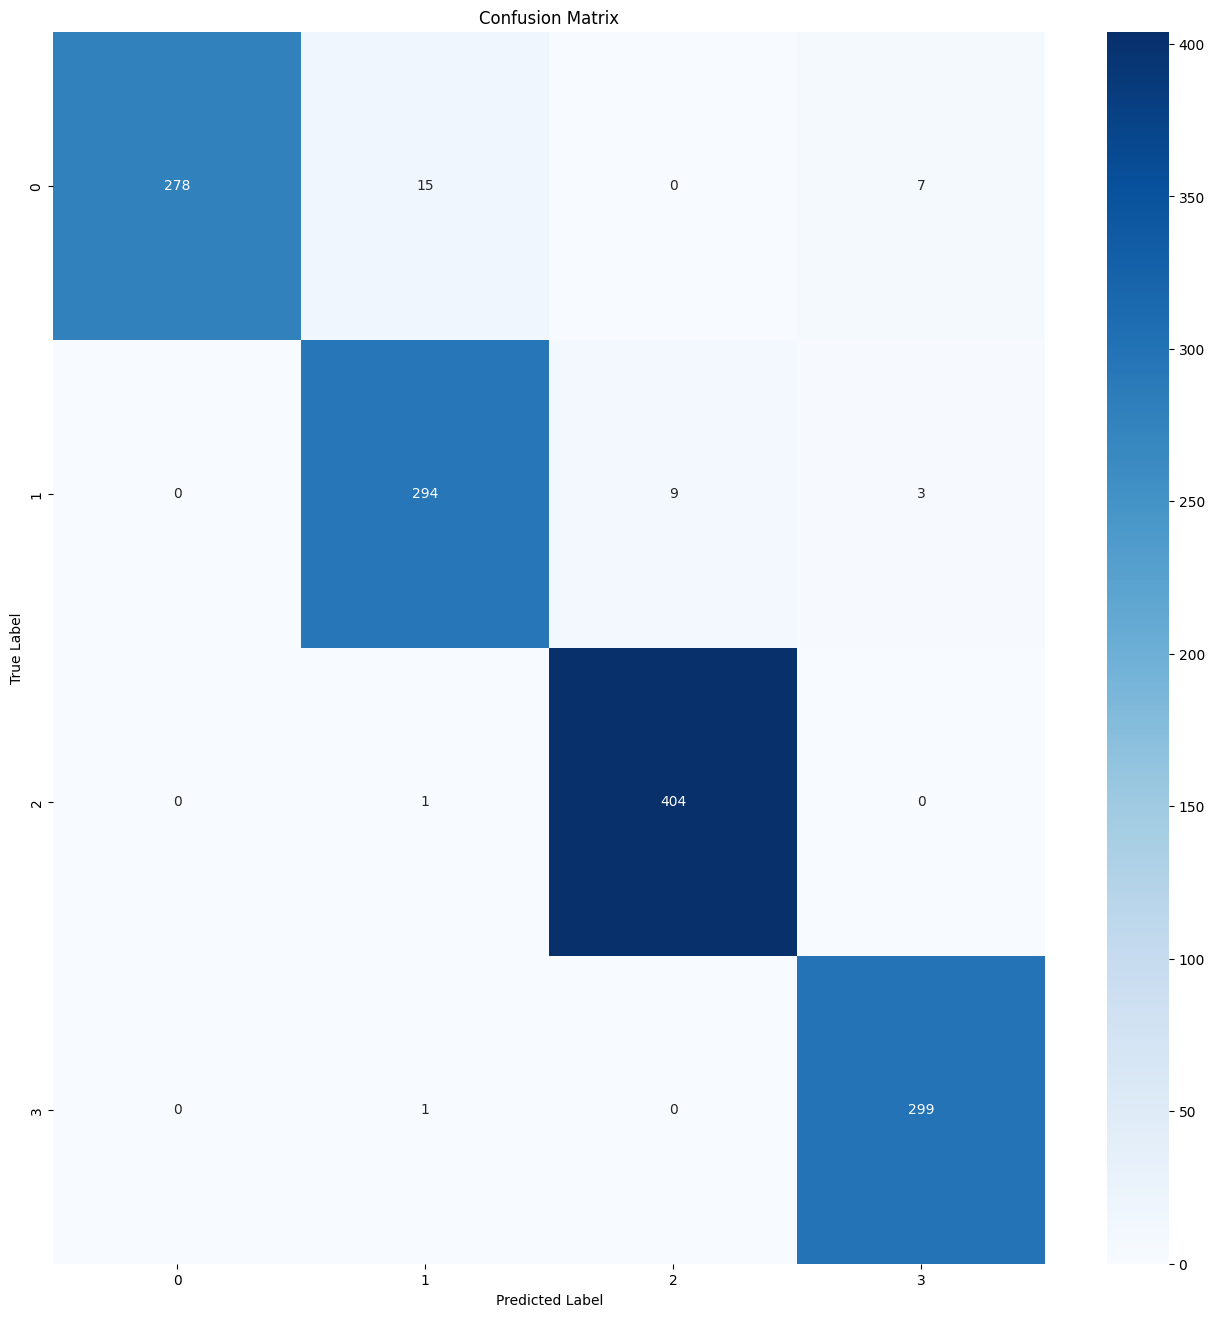

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       300
           1       0.95      0.96      0.95       306
           2       0.98      1.00      0.99       405
           3       0.97      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes from the model
predicted_classes = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
confusionmatrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))
